In [83]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import glob
import sys
import cv2 as cv
from tqdm import tqdm
from scipy import special
from scipy.stats import kstwobign, anderson

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

plt.rcParams['font.size'] = 14

In [2]:
combine_fold = 'C:/Users/oryan/Documents/mergers-in-cosmos/cats-to-combine'
data_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/back-to-basics-data'
fig_folder = 'C:/Users/oryan/Documents/mergers-in-cosmos/paper-source/figures'
cos_dat_fold = 'E:/cosmos-data'

### Importing my Data

In [3]:
df_cat = pd.read_csv(f'{combine_fold}/dor-all-restaged-full.csv', index_col = 0)

C:\Users\oryan\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
df_cat.head()

,ORyanID_23,ID,category,ALPHA_J2000,DELTA_J2000,X_IMAGE,Y_IMAGE,ERRX2_IMAGE,ERRY2_IMAGE,ERRXY_IMAGE,...,ez_ssfr_p025,ez_ssfr_p160,ez_ssfr_p500,ez_ssfr_p840,ez_ssfr_p975,ez_Av_p025,ez_Av_p160,ez_Av_p500,ez_Av_p840,ez_Av_p975
0,4000705532455,816891,stage4,150.679846,2.196543,9200.399414,21737.232422,0.000052,0.000059,-0.000010,...,-8.931825,-8.911355,-8.899668,-8.883307,-8.872990,0.529107,0.560142,0.599624,0.630920,0.652330
1,4000705533383,860686,stage3,150.644522,2.237226,10047.978516,22713.351562,0.000051,0.000046,0.000002,...,-9.314209,-9.106611,-8.941274,-8.713107,-8.541205,0.341270,0.545498,0.732327,0.906665,1.020098
2,4000705539941,1301188,stage2,149.702462,2.654895,32637.949219,32737.013672,0.000064,0.000104,-0.000003,...,-9.794128,-9.784252,-9.766013,-9.743796,-9.727879,0.018737,0.018737,0.018737,0.018737,0.018737
3,4000705540034,1304538,stage3,149.726828,2.658172,32053.712891,32815.468750,0.000071,0.000086,-0.000006,...,-9.480532,-9.443615,-9.402433,-9.352081,-9.325659,0.302629,0.376027,0.440394,0.508153,0.567727
4,4000705540064,1310001,stage3,149.701230,2.660343,32667.441406,32867.789062,0.000026,0.000020,-0.000010,...,-9.882174,-9.855921,-9.816085,-9.697225,-9.573506,0.455258,0.482555,0.522239,0.600383,0.660279


In [5]:
df_red_tmp = df_cat.query('ez_sfr < 10')
df_red = df_red_tmp.query('lp_mass_best >= 9.6')

In [6]:
len(df_red)

2800

In [7]:
df_IDS = (
    df_red[['ID', 'ID_COSMOS2015']]
)

### Importing Dervish Data

In [8]:
environ_data = pd.read_csv(f'{cos_dat_fold}/darvish17-environ.csv')

In [9]:
len(environ_data)

45421

In [10]:
environ_data_red = environ_data.query('flag == 0').rename(columns = {'ID' : 'ID_COSMOS2015'})

In [11]:
len(environ_data_red)

38865

Match on ID_COSMOS2015

### Matching Catalogues

In [12]:
df_environ_match = (
    df_IDS.merge(environ_data_red, on = 'ID_COSMOS2015', how = 'left')
)

In [13]:
matched_red = df_environ_match[['ID', 'density', 'environment']].dropna()
matched_red

,ID,density,environment
0,860686,4.23,field
1,1304538,0.96,field
2,1310001,3.08,field
3,1308927,2.78,field
4,1311422,2.26,filament
...,...,...,...
2759,1407959,29.56,cluster
2760,1408623,6.72,filament
2761,1409169,1.12,field
2762,1410323,1.47,filament


In [14]:
matched_red.density.min()

0.22

In [15]:
matched_red.density.max()

89.07

In [16]:
log_matched_red = (
    matched_red
    .assign(log_density = matched_red.density.apply(lambda x: np.log10(x)))
)

### Diagnostics of Environment Measure

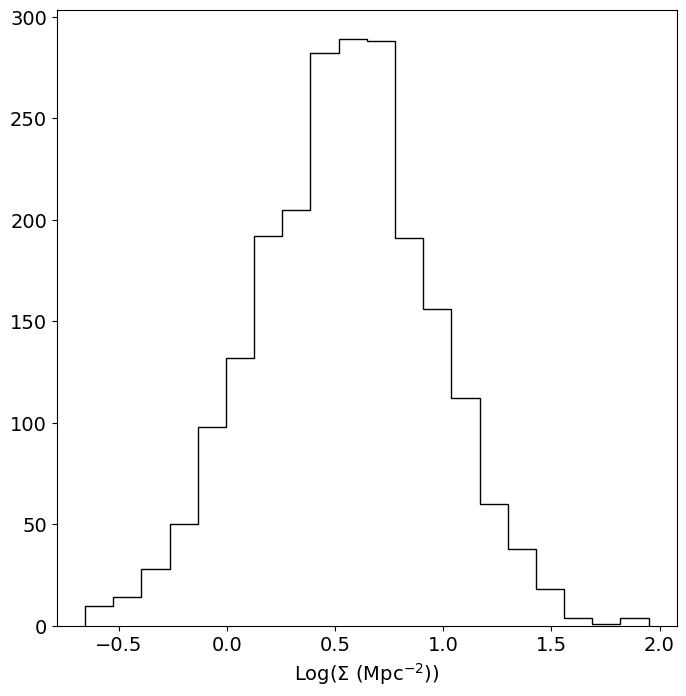

In [17]:
plt.figure(figsize = (8,8))
plt.hist(np.array(log_matched_red.log_density), bins = 20, histtype='step', color='black')
plt.xlabel('Log($\Sigma$ (Mpc$^{-2}$))')
plt.show()

In [18]:
df_cat = df_red[['ID', 'category', 'lp_mass_best', 'ez_sfr']]

In [19]:
df_environ_merg = log_matched_red.merge(df_cat, on = 'ID', how = 'left')
df_environ_merg

,ID,density,environment,log_density,category,lp_mass_best,ez_sfr
0,860686,4.23,field,0.626340,stage3,10.44862,1.609304
1,1304538,0.96,field,-0.017729,stage3,9.96798,1.101499
2,1310001,3.08,field,0.488551,stage3,10.41827,1.083541
3,1308927,2.78,field,0.444045,stage3,10.03523,1.198906
4,1311422,2.26,filament,0.354108,stage3,9.64588,0.392114
...,...,...,...,...,...,...,...
2167,1407959,29.56,cluster,1.470704,stage1,11.39123,0.488474
2168,1408623,6.72,filament,0.827369,stage1,9.82889,0.859957
2169,1409169,1.12,field,0.049218,stage4,10.24347,1.675080
2170,1410323,1.47,filament,0.167317,stage1,10.79690,1.226886


In [20]:
df_environ_merg.category.value_counts()

stage3    803
stage2    495
stage1    467
stage4    407
Name: category, dtype: int64

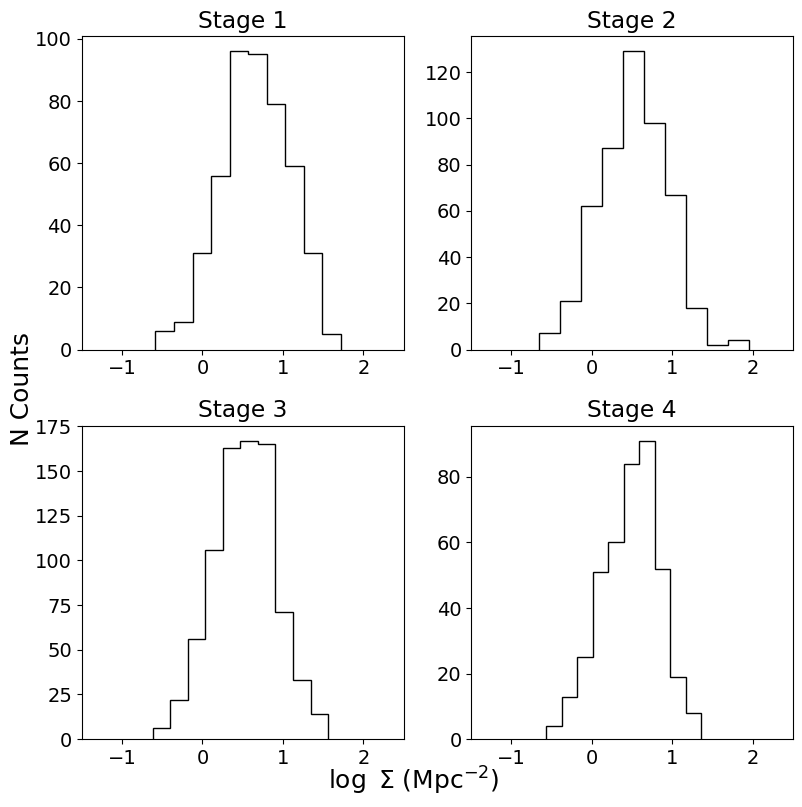

In [21]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        densities = np.array(df_environ_merg.query('category == @stage').log_density)
        
        ax[i,j].hist(densities, bins = 10, histtype='step', color='black')
        ax[i,j].set_title(f'Stage {counter}')
        ax[i,j].set_xlim([-1.5, 2.5])
        
        counter += 1

fig.tight_layout()
fig.text(0.5, 0.01, '$\log$ $\Sigma$ (Mpc$^{-2}$)', ha='center', va='center', fontsize = 18)
fig.text(0.01, 0.5, 'N Counts', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.savefig(f'{fig_folder}/density-stage.pdf', bbox_inches = 'tight')
plt.show()

### Controlling for Environment and Stage

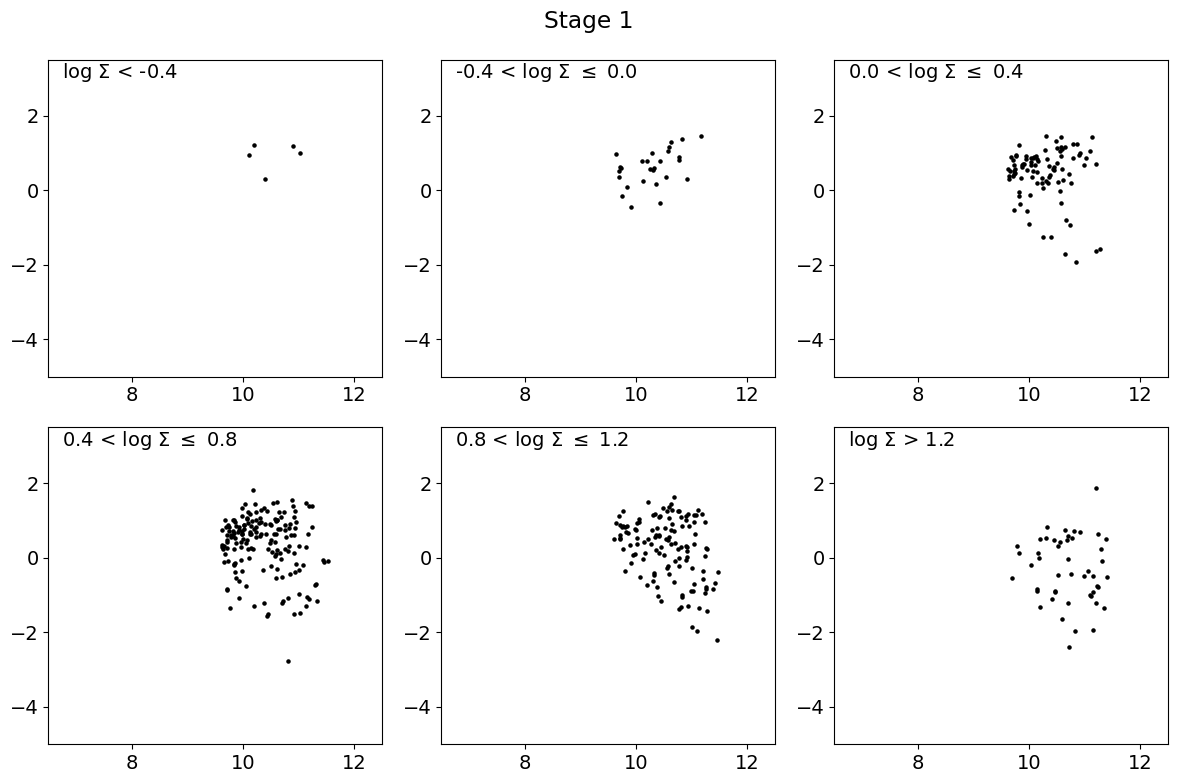

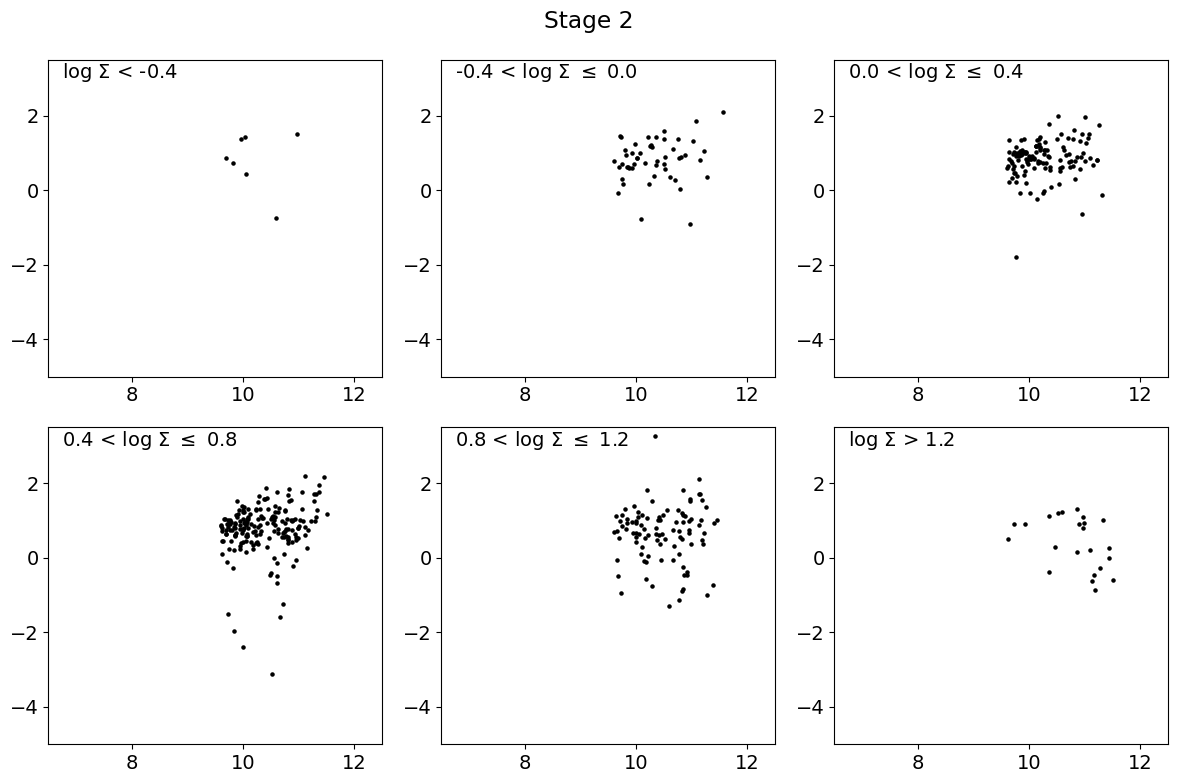

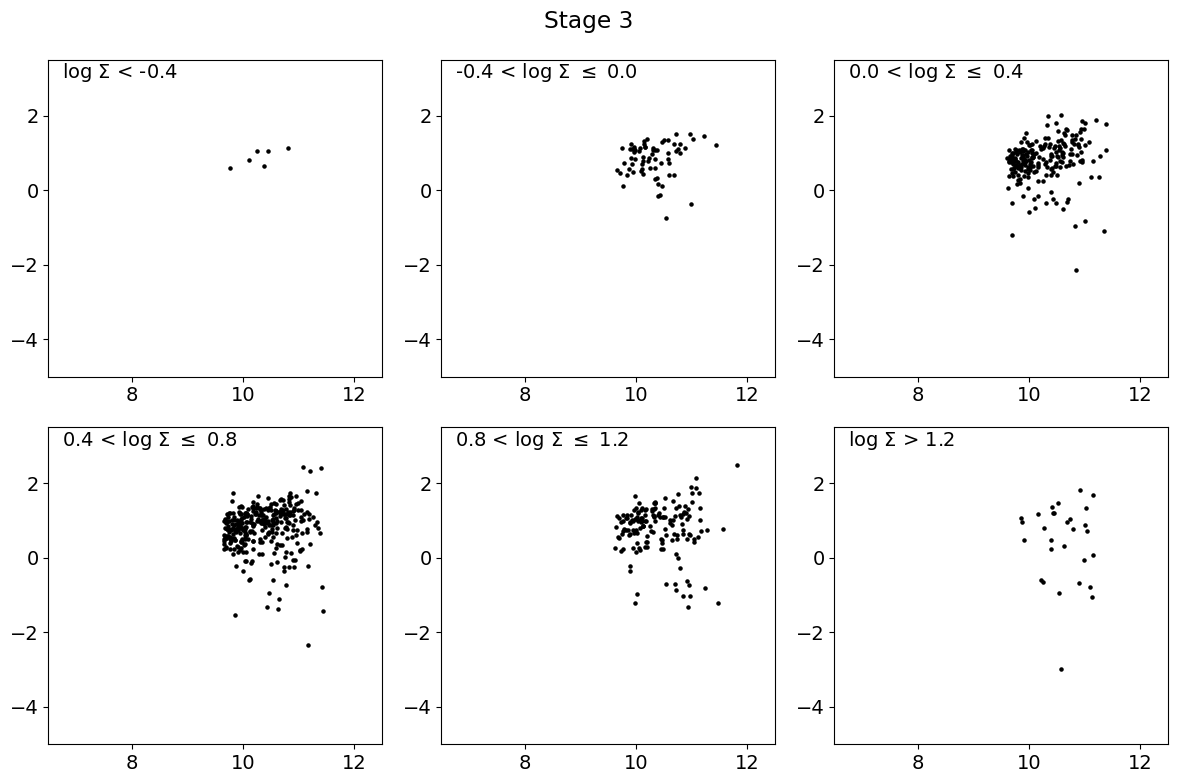

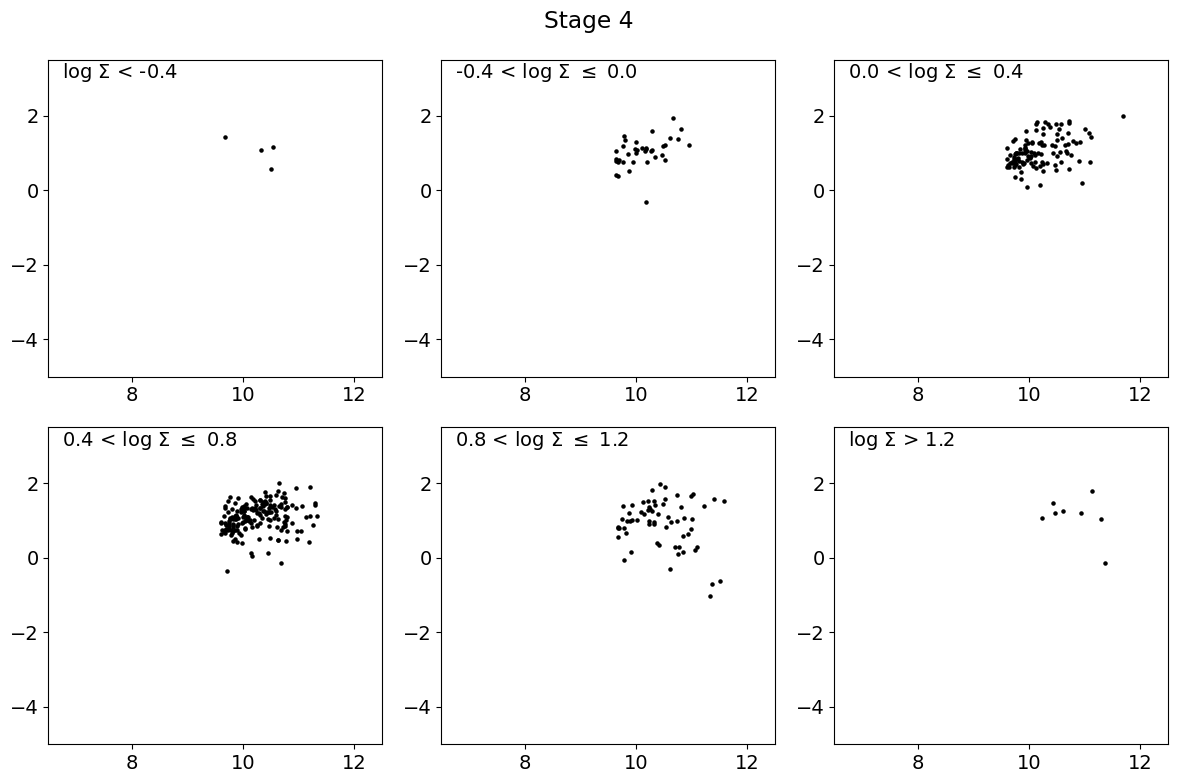

In [22]:
counter_stage = 1
cuts = [-0.4, 0.0, 0.4, 0.8, 1.2]
for i in range(4):
    fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
    stage = f'stage{counter_stage}'
    df_stage = df_environ_merg.query('category == @stage')
    counter_env = 0
    for j in range(2):
        for k in range(3):
            if counter_env == 0:
                cut = cuts[counter_env]
                df_env = df_stage.query('log_density < @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'log $\Sigma$ < {cut}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            elif counter_env < 5:
                cut_1 = cuts[counter_env - 1]
                cut_2 = cuts[counter_env]
                df_env = df_stage.query('log_density > @cut_1 and log_density <= @cut_2')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'{cut_1} < log $\Sigma$ $\leq$ {cut_2}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            elif counter_env == 5:
                cut = cuts[counter_env-1]
                df_env = df_stage.query('log_density > @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = 'black')
                ax[j,k].text(6.75, 3, f'log $\Sigma$ > {cut}')
                ax[j,k].set_xlim([6.5,12.5])
                ax[j,k].set_ylim([-5,3.5])
                counter_env += 1
            
    fig.suptitle(f'Stage {counter_stage}')
    fig.tight_layout()
                
                
    counter_stage += 1

### Trying to do in One

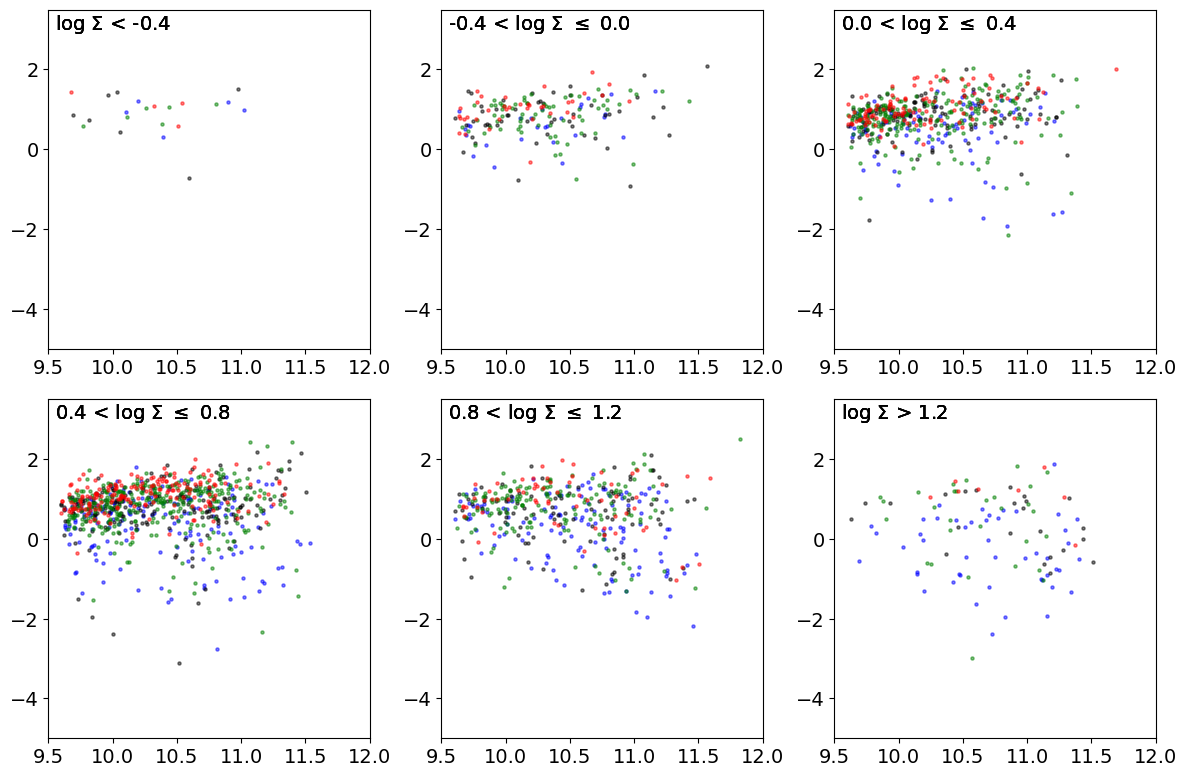

In [23]:
counter_env = 0
cuts = [-0.4, 0.0, 0.4, 0.8, 1.2]
colours = ['blue', 'black', 'green', 'red']
fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12,8))
for j in range(2):
    for k in range(3):
        counter_stage = 0
        for i in range(4):
            stage = f'stage{i+1}'
            df_stage = df_environ_merg.query('category == @stage')

            if counter_env == 0:
                cut = cuts[counter_env]
                df_env = df_stage.query('log_density < @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = colours[i], alpha=0.5)
                ax[j,k].text(9.55, 3, f'log $\Sigma$ < {cut}')
                ax[j,k].set_xlim([9.5,12.])
                ax[j,k].set_ylim([-5,3.5])
            elif counter_env < 5:
                cut_1 = cuts[counter_env - 1]
                cut_2 = cuts[counter_env]
                df_env = df_stage.query('log_density > @cut_1 and log_density <= @cut_2')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = colours[i],alpha=0.5)
                ax[j,k].text(9.55, 3, f'{cut_1} < log $\Sigma$ $\leq$ {cut_2}')
                ax[j,k].set_xlim([9.5,12.])
                ax[j,k].set_ylim([-5,3.5])
            elif counter_env == 5:
                cut = cuts[counter_env-1]
                df_env = df_stage.query('log_density > @cut')
                ax[j,k].scatter(np.array(df_env.lp_mass_best), np.array(df_env.ez_sfr), s = 5, color = colours[i],alpha=0.5)
                ax[j,k].text(9.55, 3, f'log $\Sigma$ > {cut}')
                ax[j,k].set_xlim([9.5,12.])
                ax[j,k].set_ylim([-5,3.5])
            
        counter_env += 1

fig.tight_layout()


counter_stage += 1

### Looking at Darvish Environment Classification

In [24]:
df_environ_merg

,ID,density,environment,log_density,category,lp_mass_best,ez_sfr
0,860686,4.23,field,0.626340,stage3,10.44862,1.609304
1,1304538,0.96,field,-0.017729,stage3,9.96798,1.101499
2,1310001,3.08,field,0.488551,stage3,10.41827,1.083541
3,1308927,2.78,field,0.444045,stage3,10.03523,1.198906
4,1311422,2.26,filament,0.354108,stage3,9.64588,0.392114
...,...,...,...,...,...,...,...
2167,1407959,29.56,cluster,1.470704,stage1,11.39123,0.488474
2168,1408623,6.72,filament,0.827369,stage1,9.82889,0.859957
2169,1409169,1.12,field,0.049218,stage4,10.24347,1.675080
2170,1410323,1.47,filament,0.167317,stage1,10.79690,1.226886


In [25]:
df_environ_merg.environment.value_counts()

field       948
filament    915
cluster     309
Name: environment, dtype: int64

In [26]:
environment = ['field','filament','cluster']

In [27]:
nums = [df_environ_merg.environment.value_counts().field, df_environ_merg.environment.value_counts().filament, df_environ_merg.environment.value_counts().cluster]

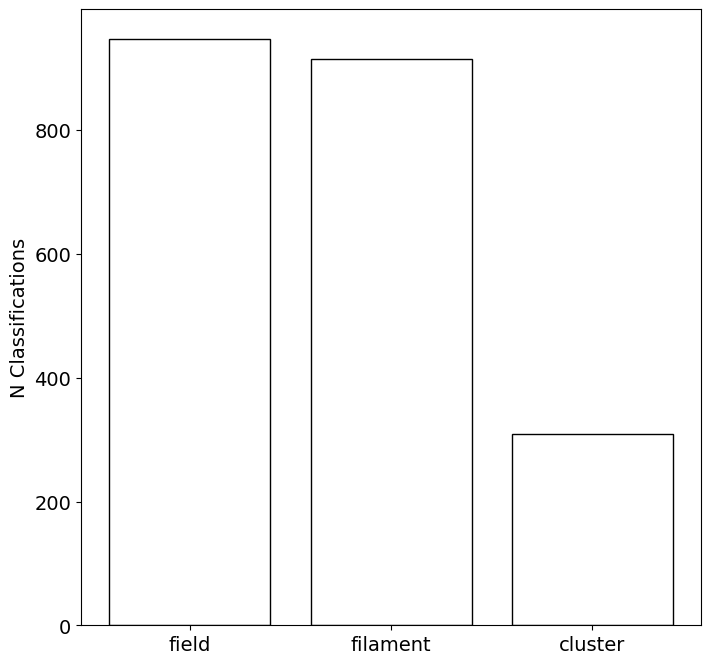

In [28]:
plt.figure(figsize = (8,8))
plt.bar(environment, nums, fill = False)
plt.ylabel('N Classifications')
plt.show()

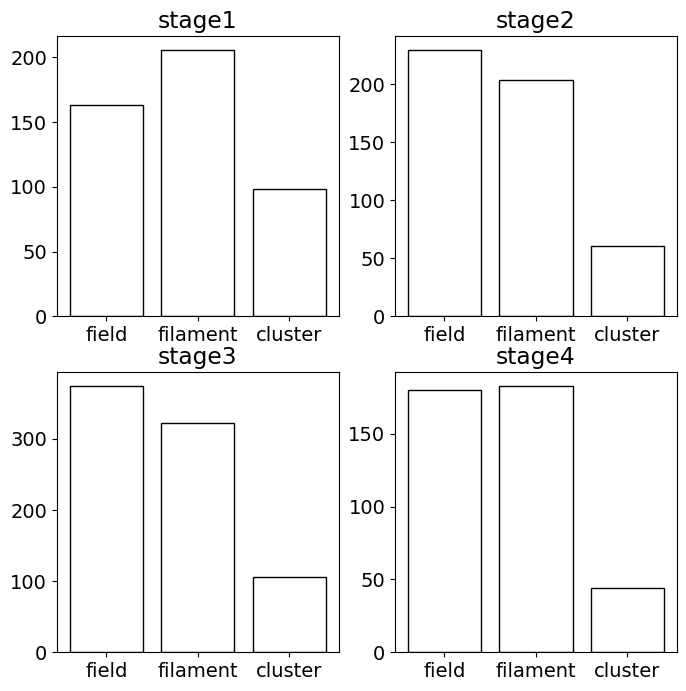

In [29]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_environ_merg.query('category == @stage')
        values = [df_stage.environment.value_counts().field, df_stage.environment.value_counts().filament, df_stage.environment.value_counts().cluster]
        
        ax[i,j].bar(environment, values, fill=False)
        ax[i,j].set_title(stage)
        
        counter += 1

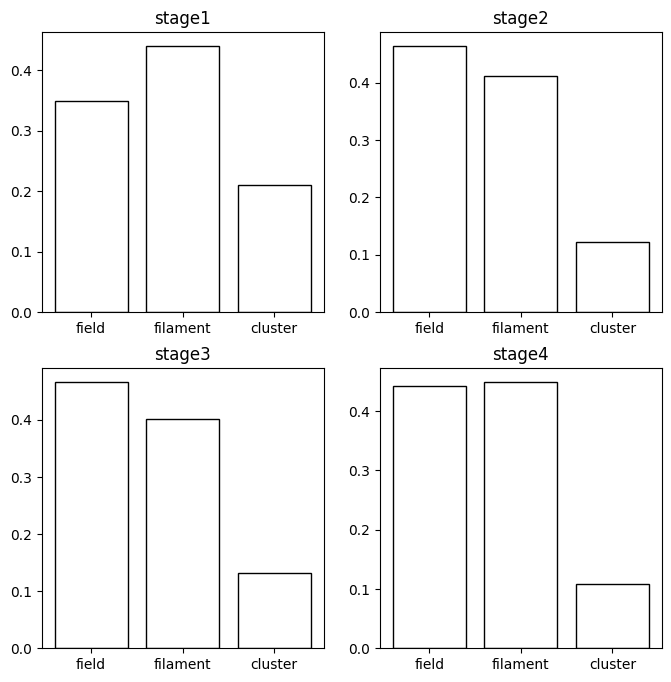

In [60]:
counter = 1
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_environ_merg.query('category == @stage')
        tot_counts = len(df_stage)
        values = [
            df_stage.environment.value_counts().field / tot_counts,
            df_stage.environment.value_counts().filament / tot_counts,
            df_stage.environment.value_counts().cluster / tot_counts
        ]
        
        ax[i,j].bar(environment, values, fill=False)
        ax[i,j].set_title(stage)
        
        counter += 1

### Above Mass-SFR plots with Environment Printed On

In [52]:
df_env_unk = (
    df_red_tmp.query('lp_mass_best > 6.5')[['ID', 'category', 'lp_mass_best', 'ez_sfr']]
    .merge(df_environ_merg[['ID', 'density', 'environment', 'log_density']], on = 'ID', how = 'left')
)

In [54]:
df_env_unk.head()

,ID,category,lp_mass_best,ez_sfr,density,environment,log_density
0,816891,stage4,9.28590,0.589695,NaN,NaN,NaN
1,860686,stage3,10.44862,1.609304,4.23,field,0.626340
2,1301188,stage2,8.72372,-0.987761,NaN,NaN,NaN
3,1304538,stage3,9.96798,1.101499,0.96,field,-0.017729
4,1310001,stage3,10.41827,1.083541,3.08,field,0.488551


In [65]:
def check_env(x):
    if type(x) == str:
        return x
    elif np.isnan(x):
        return 'unknown'
    else:
        print('Failed')
        sys.exit()

In [68]:
df_env = (
    df_env_unk
    .assign(env_clsf = df_env_unk.environment.apply(lambda x: check_env(x)))
    .drop(columns = ['density', 'log_density', 'environment'])
)

In [72]:
unk_env = ['unknown','field','filament','cluster']

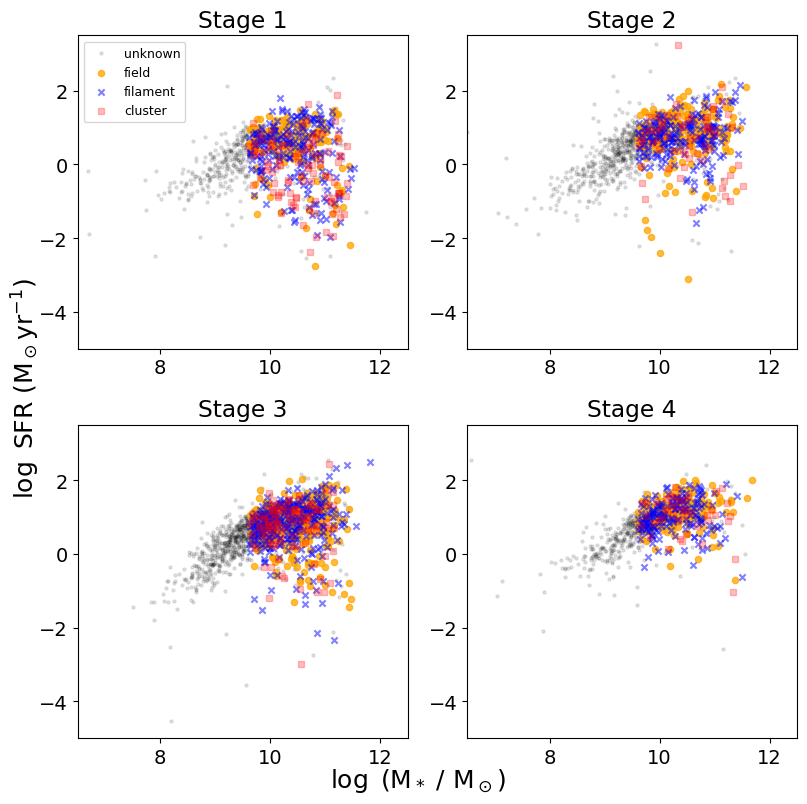

In [82]:
counter = 1
colours = ['black', 'orange', 'blue', 'red']
markers = ['.', 'o', 'x', 's']
alphas = [0.10, 0.75, 0.5, 0.25]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (8,8))
for i in range(2):
    for j in range(2):
        stage = f'stage{counter}'
        df_stage = df_env.query('category == @stage')
        
        for color_count, env in enumerate(unk_env):
            df_env_tmp = df_stage.query('env_clsf == @env')
            ax[i,j].scatter(np.array(df_env_tmp.lp_mass_best), np.array(df_env_tmp.ez_sfr), color=colours[color_count], marker = markers[color_count], s = 20, alpha = alphas[color_count])
        ax[i,j].set_title(f'Stage {counter}')
        ax[i,j].set_xlim([6.5,12.5])
        ax[i,j].set_ylim([-5,3.5])
        
        counter += 1
ax[0,0].legend(unk_env, loc = 'upper left', fontsize = 9)
fig.text(0.5, 0.01, '$\log$ (M$_*$ / M$_\odot$)', ha='center', va='center', fontsize = 18)
fig.text(0.01, 0.5, '$\log$ SFR (M$_\odot$yr$^{-1}$)', ha='center', va='center', rotation='vertical', fontsize = 18)
fig.tight_layout()
fig.savefig(f'{fig_folder}/sfr-mass-density.pdf', bbox_inches = 'tight')
plt.show()

### KS Testing

In [84]:
def ks_weighted(arr1_all, arr2_all, w1_all, w2_all, return_dist=False):

    '''
    Given 2 arrays and their weights, returns Kolmogorov-Smirnov statistic and significance.

    This differs from the usual K-S test in that it computes a weighted K-S statistic and
    assumes the size of each sample is equal to the sum of the weights, not the length of
    the array. It's not exactly standard statistical practice to do this, so use with 
    caution, but it doesn't seem like a completely ridiculous idea, either.

        Parameters:
            arr1_all   (array): a data sample with values to be weighted by w1_all
            arr2_all   (array): a data sample with values to be weighted by w2_all
            w1_all     (array): weights for arr1_all
            w2_all     (array): weights for arr2_all
            return_dist (bool): True if the array of all K-S distances should be returned,
                                default is False (mostly only useful for debugging)

            Note: the arrays should be np.array() but other data types based on that should
                  work too, e.g. pd.Series, Astropy Table columns, etc. -- but if you get
                  an error on those, wrap your inputs with np.array().

        Returns:
            ks:     the weighted, 2-sided K-S statistic
            p_ks:   the p-value based on the weighted K-S statistic
            sig_ks: the significance level (in sigma) assuming p-values are distributed Normally

            if return_dist == True, also:
                dist_arr: array of KS-distances in raw format (sorted by increasing data sample value)
                          seriously this is not useful statistically, it's just for debugging

    '''

    # drop dead weight
    arr1 = np.array(arr1_all[w1_all > 0.0])
    arr2 = np.array(arr2_all[w2_all > 0.0])
    w1   = np.array(  w1_all[w1_all > 0.0])
    w2   = np.array(  w2_all[w2_all > 0.0])

    # get effective lengths of the weighted arrays
    n1 = np.sum(w1)
    n2 = np.sum(w2)
 
    # this is used below in the k-s calculation
    # (weighted sample sizes)
    ct = np.sqrt((n1+n2)/(n1*n2))

    # we want to sort the arrays, and the weights
    i1 = arr1.argsort()
    i2 = arr2.argsort()

    # sort arrays and weights in increasing order
    arr1_s = np.array(arr1[i1])
    w1_s   = np.array(  w1[i1])
    arr2_s = np.array(arr2[i2])
    w2_s   = np.array(  w2[i2])

    # make combined arrays but track which element comes from what, then sort them again
    both   = np.concatenate([arr1_s, arr2_s])
    both_w = np.concatenate([  w1_s,   w2_s])
    track  = np.concatenate([np.zeros(len(arr1_s), dtype=int), np.ones(len(arr2_s), dtype=int)])

    i_both   = both.argsort()
    both_s   = np.array(  both[i_both])
    both_w_s = np.array(both_w[i_both])
    track_s  = np.array( track[i_both])

    # go through array, once, computing the distance as we go, and track the max distance between cumulative curves
    # (which are both stored in the same array)
    # both cumulative curves start at 0 so the distance starts at 0
    # also cumulative curves always increase
    the_dist = 0.0
    dist_arr = np.zeros_like(both_s)
    max_dist = 0.0
    for j, this_which in enumerate(track_s):
        # the key here is the distance between curves goes up if array A has a new value,
        # and then if B has a new value that curve increases too so the curves get closer together
        # (the distance goes down).
        # it doesn't matter which is curve A and which is curve B, just that one increments 
        # and the other decrements.
        # if we were doing a regular K-S without weights, each new value for a given array changes
        # the distance between curves by 1 count. 
        # (with weighted, it only changes the distance by that object's weight.)
        # And also, these are cumulative curves, so each curve is divided by the total counts in that array
        # (which in the weighted case means the sum of the weights)
        # as a check, the distances should start at 0 and end at 0 (because the cumulative fractional
        # histograms both start at 0.0 and end at 1.0)
        if this_which == 0:
            the_dist += both_w_s[j]/n1
        else:
            the_dist -= both_w_s[j]/n2

        dist_arr[j] = the_dist
        if np.abs(the_dist) > max_dist:
            max_dist = np.abs(the_dist) 

    # the max dist over the whole cumulative curves is the K-S distance
    ks = max_dist
    # p-value (which also cares about the sample sizes)
    p_ks   = special.kolmogorov(float(ks)/float(ct))
    # scipy.stats.ks_2samp uses this instead?
    p_ksalt   = kstwobign.sf(((1./ct) + 0.12 + (0.11 * ct)) * ks)
    #print(p_ksalt)

    # what's the significance assuming a normal distribution? (1 = 1 sigma, 2. = 2 sigma, 3. = 3 sigma result etc.)
    sig_ks = special.erfcinv(p_ks)*np.sqrt(2.)



    if return_dist:
        return ks, p_ks, sig_ks, dist_arr
    else: 
        return ks, p_ks, sig_ks

In [86]:
def weight_dist(arr1, arr2, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    w1 = np.zeros_like(arr1)
    w2 = np.zeros_like(arr2)

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to

    hist1, thebins = np.histogram(arr1, bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hist2, thebins = np.histogram(arr2, bins=thebins)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        # zero-"index"ing these because they're indices and not values
        # and if I get them mixed up below I want this to error that there's no b2 or whatever
        b0 = thebins[i_bin]
        b1 = thebins[i_bin+1]

        count1 = hist1[i_bin]
        count2 = hist2[i_bin]

        # don't miss any values and don't double-count
        if i_bin == 0:
            in_bin1 = (arr1 >= b0) & (arr1 <= b1)
            in_bin2 = (arr2 >= b0) & (arr2 <= b1)
        else: 
            in_bin1 = (arr1 >  b0) & (arr1 <= b1)
            in_bin2 = (arr2 >  b0) & (arr2 <= b1)


        # don't divide by 0 in the rest of the if/else
        if (count1 == 0) | (count2 == 0):
            w1[in_bin1] = 0.0
            w2[in_bin2] = 0.0

        elif count1 < count2:
            # weight count2 values so the sum of wt2 in this bin equals count1
            # wt_fac will always be < 1
            wt_fac = float(count1)/float(count2)
            w1[in_bin1] = 1.0
            w2[in_bin2] = wt_fac

        else:
            # weight count1 values so the sum of wt1 in this bin equals count2
            # wt_fac will always be <= 1
            wt_fac = float(count2)/float(count1)
            w1[in_bin1] = wt_fac
            w2[in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(w1) > 0.00000) & (np.amax(w1) < 1.0):
            w1 /= np.amax(w1)

        if (np.sum(w2) > 0.00000) & (np.amax(w2) < 1.0):
            w2 /= np.amax(w2)


    if return_bins:
        return w1, w2, thebins 
    else: 
        return w1, w2

In [87]:
def weight_dist_list(arrs, bins=None, return_bins=True, renorm=False):
    # this will take 2 arrays of values from 2 different samples
    # e.g. redshift distributions from 2 samples
    # and return weights for each value such that the weighted
    # distributions of each sample will match.

    # note the bins need to be the same for both datasets
    # so either supply 1 number or 1 array of bin edges
    # also if you have fully specified the bins you don't need them returned
    # but if we've had to figure them out, you do need them returned
    # if you want to make sure you aren't under-weighting (e.g. if a whole dataset is
    # much larger than the other so you might always be able select >1 object
    # in dataset 1 for each object in dataset 2) then you can re-normalise to make
    # sure the max weight of both datasets is 1
    # Note, if the distributions cross this won't make a difference

    # weight arrays
    # w1 = np.zeros_like(arr1)
    # w2 = np.zeros_like(arr2)
    
    ws_list = []
    for i in arrs:
        ws_list.append(np.zeros_like(i))

    # if bins not specified, guess at them ourselves
    if bins is None:
        minsize = np.amin([    len(arr1),     len(arr2)])
        themin  = np.amin([np.amin(arr1), np.amin(arr2)])
        themax  = np.amax([np.amax(arr1), np.amax(arr2)])

        # on average 5 data points per bin, but at least 3 bins pls, max value is last bin edge
        bins = np.linspace(themin, themax, int(np.amax([(minsize/5)+1, 3])), endpoint=True)

    else:
        pass
        # because the np.histogram function can deal with distinguishing between number of bins or specific bins itself
        # so we don't have to
    hists = []
    hist1, thebins = np.histogram(arrs[0], bins=bins)  # returns (counts_arr, bins_arr)
    # use the bins from hist1 to make hist2
    # note: for these purposes, any values of hist2 outside the minmax range of hist1 should have 0 weight
    # which is taken care of by the zeros_like initialisation of w1 and w2 above
    # so it's fine for them to be excluded below
    hists.append(hist1)
    for i in arrs[1:]:
        hist_tmp, thebins = np.histogram(i, bins=thebins)
        hists.append(hist_tmp)

    # now step through the bins and assign weights
    for i_bin in range(len(thebins)-1):
        for i_hist in range(len(hists)-1):
            # zero-"index"ing these because they're indices and not values
            # and if I get them mixed up below I want this to error that there's no b2 or whatever
            b0 = thebins[i_bin]
            b1 = thebins[i_bin+1]

            count1 = hists[3][i_bin]
            count2 = hists[i_hist][i_bin]

            # don't miss any values and don't double-count
            if i_bin == 0:
                in_bin1 = (arrs[3] >= b0) & (arrs[3] <= b1)
                in_bin2 = (arrs[i_hist] >= b0) & (arrs[i_hist] <= b1)
            else: 
                in_bin1 = (arrs[3] >  b0) & (arrs[3] <= b1)
                in_bin2 = (arrs[i_hist] >  b0) & (arrs[i_hist] <= b1)


            # don't divide by 0 in the rest of the if/else
            if (count1 == 0) | (count2 == 0):
                ws_list[3][in_bin1] = 0.0
                ws_list[i_hist][in_bin2] = 0.0

            elif count1 < count2:
                # weight count2 values so the sum of wt2 in this bin equals count1
                # wt_fac will always be < 1
                wt_fac = float(count1)/float(count2)
                ws_list[3][in_bin1] = 1.0
                ws_list[i_hist][in_bin2] = wt_fac

            else:
                # weight count1 values so the sum of wt1 in this bin equals count2
                # wt_fac will always be <= 1
                wt_fac = float(count2)/float(count1)
                ws_list[3][in_bin1] = wt_fac
                ws_list[i_hist][in_bin2] = 1.0


    # now the weights should be determined
    # we can optionally re-normalise to make sure we are getting max value out of the datasets
    if renorm:
        if (np.sum(ws) > 0.00000) & (np.amax(w1) < 1.0):
            ws /= np.amax(ws)

        if (np.sum(ws) > 0.00000) & (np.amax(w2) < 1.0):
            ws /= np.amax(ws)


    if return_bins:
        return ws, thebins 
    else: 
        return ws_list

In [89]:
df_environ_merg.head()

,ID,density,environment,log_density,category,lp_mass_best,ez_sfr
0,860686,4.23,field,0.626340,stage3,10.44862,1.609304
1,1304538,0.96,field,-0.017729,stage3,9.96798,1.101499
2,1310001,3.08,field,0.488551,stage3,10.41827,1.083541
3,1308927,2.78,field,0.444045,stage3,10.03523,1.198906
4,1311422,2.26,filament,0.354108,stage3,9.64588,0.392114


In [91]:
log_den_s1 = np.array(df_environ_merg.query('category == "stage1"')['log_density'])
log_den_s2 = np.array(df_environ_merg.query('category == "stage2"')['log_density'])
log_den_s3 = np.array(df_environ_merg.query('category == "stage3"')['log_density'])
log_den_s4 = np.array(df_environ_merg.query('category == "stage4"')['log_density'])

In [99]:
weights = weight_dist_list([log_den_s1, log_den_s2, log_den_s3, log_den_s4], bins = 20, renorm = False, return_bins = False)

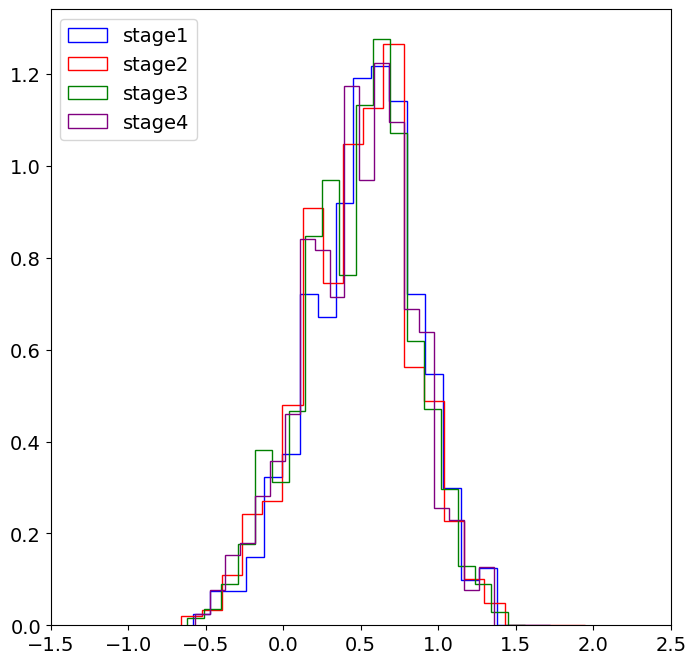

In [103]:
fig, ax = plt.subplots(figsize = (8,8))

ax.hist(log_den_s1, bins = 20, histtype='step', color='blue', weights=weights[0],density=True)
ax.hist(log_den_s2, bins = 20, histtype='step', color='red', weights=weights[1],density=True)
ax.hist(log_den_s3, bins = 20, histtype='step', color='green', weights=weights[2],density=True)
ax.hist(log_den_s4, bins = 20, histtype='step', color='purple',weights=weights[3],density=True)
ax.set_xlim([-1.5, 2.5])
plt.legend(['stage1','stage2','stage3','stage4'], loc='upper left')
plt.show()

In [104]:
weights_s1, weights_s2 = weight_dist(log_den_s1, log_den_s2, bins = 20, renorm = False, return_bins = False)
weights_s1_s3, weights_s3 = weight_dist(log_den_s1, log_den_s3, bins = 20, renorm = False, return_bins = False)
weights_s1_s4, weights_s4 = weight_dist(log_den_s1, log_den_s4, bins = 20, renorm = False, return_bins = False)

In [105]:
ks_m_12, p_ks_m_12, sig_ks_12 = ks_weighted(log_den_s1, log_den_s2, weights_s1, weights_s2, return_dist=False)
ks_m_13, p_ks_m_13, sig_ks_13 = ks_weighted(log_den_s1, log_den_s3, weights_s1_s3, weights_s3, return_dist=False)
ks_m_14, p_ks_m_14, sig_ks_14 = ks_weighted(log_den_s1, log_den_s4, weights_s1_s4, weights_s4, return_dist=False)

In [106]:
weights_s2_s3, weights_s3 = weight_dist(log_den_s2, log_den_s3, bins = 20, renorm = False, return_bins = False)
weights_s2_s4, weights_s4 = weight_dist(log_den_s2, log_den_s4, bins = 20, renorm = False, return_bins = False)

In [107]:
ks_m_23, p_ks_m_23, sig_ks_23 = ks_weighted(log_den_s2, log_den_s3, weights_s2_s3, weights_s3, return_dist=False)
ks_m_24, p_ks_m_24, sig_ks_24 = ks_weighted(log_den_s2, log_den_s4, weights_s2_s4, weights_s4, return_dist=False)

In [108]:
weights_s3_s4, weights_s4 = weight_dist(log_den_s3, log_den_s4, bins = 20, renorm = False, return_bins = False)

In [109]:
ks_m_34, p_ks_m_34, sig_ks_34 = ks_weighted(log_den_s3, log_den_s4, weights_s3_s4, weights_s4, return_dist=False)

In [110]:
print(f'KS Score Density between stages 1 and 2 = {ks_m_12}')
print(f'KS Score Density between stages 1 and 3 = {ks_m_13}')
print(f'KS Score Density between stages 1 and 4 = {ks_m_14}')
print(f'KS Score Density between stages 2 and 3 = {ks_m_23}')
print(f'KS Score Density between stages 2 and 4 = {ks_m_24}')
print(f'KS Score Density between stages 3 and 4 = {ks_m_34}')
print(' ')
print(f'KS-test p-value Density between stages 1 and 2 = {p_ks_m_12}')
print(f'KS-test p-value Density between stages 1 and 3 = {p_ks_m_13}')
print(f'KS-test p-value Density between stages 1 and 4 = {p_ks_m_14}')
print(f'KS-test p-value Density between stages 2 and 3 = {p_ks_m_23}')
print(f'KS-test p-value Density between stages 2 and 4 = {p_ks_m_24}')
print(f'KS-test p-value Density between stages 3 and 4 = {p_ks_m_34}')
print(' ')
print(f'KS-test significance Density between stages 1 and 2 = {sig_ks_14}')
print(f'KS-test significance Density between stages 1 and 3 = {sig_ks_24}')
print(f'KS-test significance Density between stages 1 and 4 = {sig_ks_34}')
print(f'KS-test significance Density between stages 2 and 3 = {sig_ks_23}')
print(f'KS-test significance Density between stages 2 and 4 = {sig_ks_24}')
print(f'KS-test significance Density between stages 3 and 4 = {sig_ks_34}')

KS Score Density between stages 1 and 2 = 0.02794770301067535
KS Score Density between stages 1 and 3 = 0.032490340709518784
KS Score Density between stages 1 and 4 = 0.040114613180515735
KS Score Density between stages 2 and 3 = 0.028682959945689084
KS Score Density between stages 2 and 4 = 0.03214071407140713
KS Score Density between stages 3 and 4 = 0.03159819438889205
 
KS-test p-value Density between stages 1 and 2 = 0.997770941360271
KS-test p-value Density between stages 1 and 3 = 0.9749101587165651
KS-test p-value Density between stages 1 and 4 = 0.9415447548231801
KS-test p-value Density between stages 2 and 3 = 0.9875920367454327
KS-test p-value Density between stages 2 and 4 = 0.9851497638139781
KS-test p-value Density between stages 3 and 4 = 0.9871715005255959
 
KS-test significance Density between stages 1 and 2 = 0.07332844746940992
KS-test significance Density between stages 1 and 3 = 0.018613085639713433
KS-test significance Density between stages 1 and 4 = 0.016078832